In [1]:
import pandas as pd
import numpy as np
import random
from random import choice
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 再現性確保
random.seed(42)
np.random.seed(42)



=== ターゲットとの相関係数 ===
適温         1.000000
室温         0.950770
室温_min3    0.945308
室温_ma3     0.942915
室温_lag1    0.940444
室温_max3    0.936912
体温_ma3     0.803161
体温_lag1    0.751599
体温         0.744581
Name: 適温, dtype: float64


c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\bsksh\Documents\program

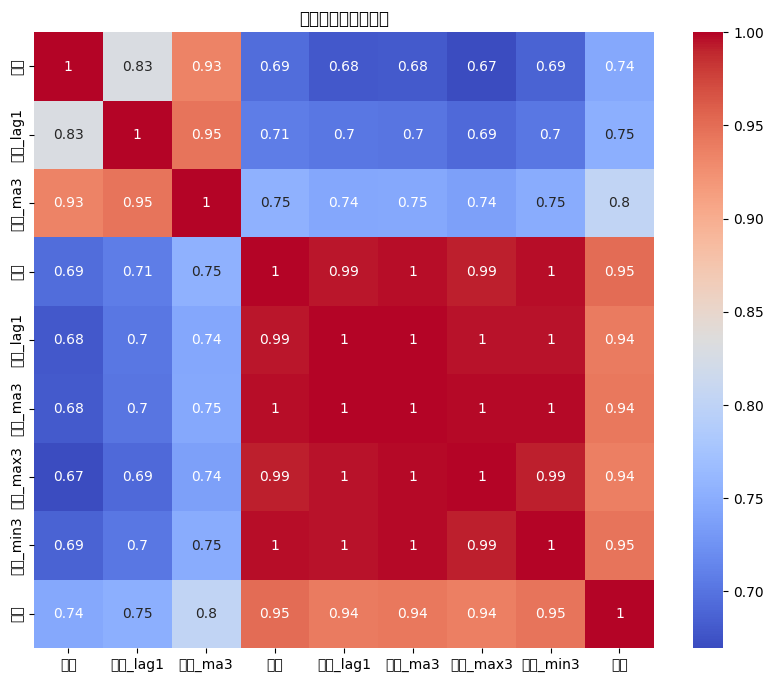

[0]	train-rmse:1.57983	eval-rmse:0.95169
[20]	train-rmse:0.91574	eval-rmse:0.70868
[40]	train-rmse:0.55800	eval-rmse:0.67538
[60]	train-rmse:0.37291	eval-rmse:0.68828
[80]	train-rmse:0.28806	eval-rmse:0.71613
[86]	train-rmse:0.27243	eval-rmse:0.72280
Test MSE: 0.5224
Test RMSE: 0.7228
Test MAE: 0.6169
Test R^2 Score: 0.3277

=== 特徴量重要度 ===
   feature  importance
3       室温       125.0
5   室温_ma3        49.0
2   体温_ma3        45.0
7  室温_min3        44.0
4  室温_lag1        29.0
6  室温_max3        26.0
0       体温        10.0
1  体温_lag1         3.0


c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23460 (\N{CJK UNIFIED IDEOGRAPH-5BA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


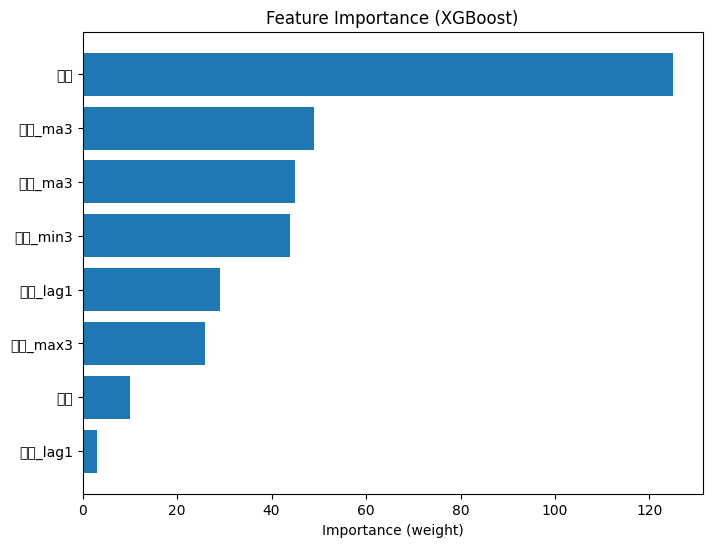

In [2]:
import pandas as pd
import numpy as np

# ファイル読み込み
df = pd.read_csv("../datasets/ring_data.csv")

# --- ラグ特徴 ---
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温'].shift(1)

# --- 差分特徴量（デルタ温度）---
df['delta_temp'] = df['室温'] - df['体温']
df['delta_temp_lag1'] = df['室温_lag1'] - df['体温_lag1']

# --- 移動平均・移動分散（ウィンドウサイズ3）---
window_size = 3
df['体温_ma3'] = df['体温'].rolling(window=window_size).mean()
df['体温_var3'] = df['体温'].rolling(window=window_size).var()
df['室温_ma3'] = df['室温'].rolling(window=window_size).mean()
df['室温_var3'] = df['室温'].rolling(window=window_size).var()

# --- 新しい特徴量エンジニアリング ---

# 2次差分（delta_tempの差分）
df['delta_temp_2diff'] = df['delta_temp'].diff()

# 移動中央値、最大、最小
df['体温_median3'] = df['体温'].rolling(window=window_size).median()
df['体温_max3'] = df['体温'].rolling(window=window_size).max()
df['体温_min3'] = df['体温'].rolling(window=window_size).min()

df['室温_median3'] = df['室温'].rolling(window=window_size).median()
df['室温_max3'] = df['室温'].rolling(window=window_size).max()
df['室温_min3'] = df['室温'].rolling(window=window_size).min()

# 移動範囲 (max - min)
df['体温_range3'] = df['体温_max3'] - df['体温_min3']
df['室温_range3'] = df['室温_max3'] - df['室温_min3']

# 3点の線形トレンド（傾き）計算用関数
def calc_slope(series):
    x = np.arange(len(series))
    y = series.values
    if len(y) < 3 or np.any(pd.isnull(y)):
        return np.nan
    slope = np.polyfit(x, y, 1)[0]
    return slope

df['体温_trend3'] = df['体温'].rolling(window=window_size).apply(calc_slope, raw=False)
df['室温_trend3'] = df['室温'].rolling(window=window_size).apply(calc_slope, raw=False)

# 欠損値削除（shiftやrollingでできたNaNを削除）
df.dropna(inplace=True)

# 特徴量リストに新しい特徴量を追加
features = [
    '体温', '体温_lag1', '体温_ma3', 
    '室温', '室温_lag1', '室温_ma3',  
     '室温_max3', '室温_min3'
]

target = '適温'


# --- ここから相関行列の確認 ---
df_features = df[features + [target]]
corr_matrix = df_features.corr()

# ターゲットとの相関だけ表示
target_corr = corr_matrix[target].sort_values(ascending=False)
print("=== ターゲットとの相関係数 ===")
print(target_corr)

# 相関ヒートマップ表示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('特徴量間の相関行列')
plt.show()

# --- 学習データ準備 ---
X_raw = df[features].values
y_raw = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, shuffle=False, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'reg_alpha': 0.15,
    'reg_lambda': 1.2,
    'min_child_weight': 3,
    'gamma': 1.0,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=20
)

# 予測
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

# --- 特徴量重要度の表示 ---
importance = model.get_score(importance_type='weight')  # 'weight'は分割で使われた回数
# 辞書なのでDataFrameに変換
feat_imp_df = pd.DataFrame({
    'feature': [f'f{i}' for i in range(len(features))],
    'importance': [importance.get(f'f{i}', 0) for i in range(len(features))]
})
# f0,f1,...を実際の特徴量名に置き換え
feat_imp_df['feature'] = features

feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print("\n=== 特徴量重要度 ===")
print(feat_imp_df)

# プロット
plt.figure(figsize=(8,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Importance (weight)')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.show()


C:\Users\bsksh\AppData\Local\Temp\ipykernel_11408\2984177277.py:12: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_11408\2984177277.py:12: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_11408\2984177277.py:12: UserWarning: Glyph 23455 (\N{CJK UNIFIED IDEOGRAPH-5B9F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_11408\2984177277.py:12: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_11408\2984177277.py:12: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_11408\2984177277.py:12: UserWarning: Glyph 12392 (\

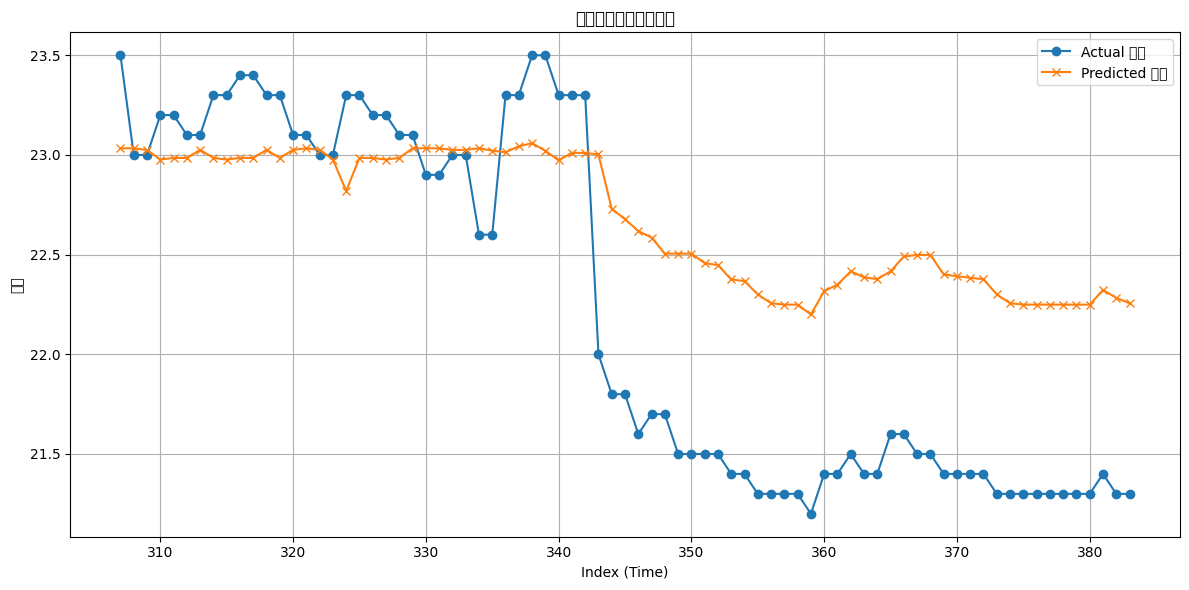

In [3]:
# テストデータのインデックス取得（分割前の元dfのインデックスを活用）
test_index = df.index[-len(y_test):]

plt.figure(figsize=(12,6))
plt.plot(test_index, y_test, label='Actual 適温', marker='o')
plt.plot(test_index, y_pred, label='Predicted 適温', marker='x')
plt.xlabel('Index (Time)')
plt.ylabel('適温')
plt.title('実測値と予測値の比較')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
import os


# 評価指標を辞書でまとめる
results_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2]
}

# DataFrameに変換
results_df = pd.DataFrame(results_dict)

# 保存先ディレクトリ
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)  # フォルダがなければ作成

# 保存ファイル名
filename = "ring_xgb.csv"  

# フルパスを作成
filepath = os.path.join(results_dir, filename)

# CSV保存（indexは不要）
results_df.to_csv(filepath, index=False)

print(f"評価結果を保存しました: {filepath}")


評価結果を保存しました: ../results\ring_xgb.csv
